# Project: Build a Traffic Sign Recognition Classifier

In this project, I use deep neural networks and convolutional neural networks to classify traffic signs. I will train and validate a model so it can classify traffic sign images using the German Traffic Sign Dataset (http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset). After the model is trained, I will then try out your model on images of German traffic signs that I find from Google map steetview.

---
## Step 1: Load The Data

In [2]:
# all imports
import time
import pickle
import csv
import operator
from itertools import groupby
from collections import OrderedDict

import cv2
import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers import flatten

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline

from utils import *

In [7]:
training_file = '/Users/rrjing85/AutoDriveCar/Traffic_sign_project/traffic-signs-data/train.p'
testing_file = '/Users/rrjing85/AutoDriveCar/Traffic_sign_project/traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)

with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

classes = [i for i in range(44)]

X, Y = train['features'], train['labels']

X_test, y_test = test['features'], test['labels']

In [8]:
### Replace each question mark with the appropriate value.
# Number of training examples
n_train = len(X)
#Number of testing examples.
n_test = len(X)

#the shape of an traffic sign image
image_shape = X[0].shape

#How many unique classes/labels there are in the dataset.
n_classes = len(set(list(Y)))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 39209
Image data shape = (32, 32, 3)
Number of classes = 43


In [12]:
names = {}
with open('/Users/rrjing85/AutoDriveCar/Traffic_sign_project/traffic-signs-data/signnames.csv') as _f:
    rows = csv.reader(_f, delimiter=',')
    next(rows, None)  # skip the headers
    for row in rows:
        names[str(row[0])] = row[1]

---

## Step 2: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Visualize the German Traffic Signs Dataset using the pickled file(s).

In [13]:
X_train, Y_train, X_val, Y_val = train_test_split(X, Y)

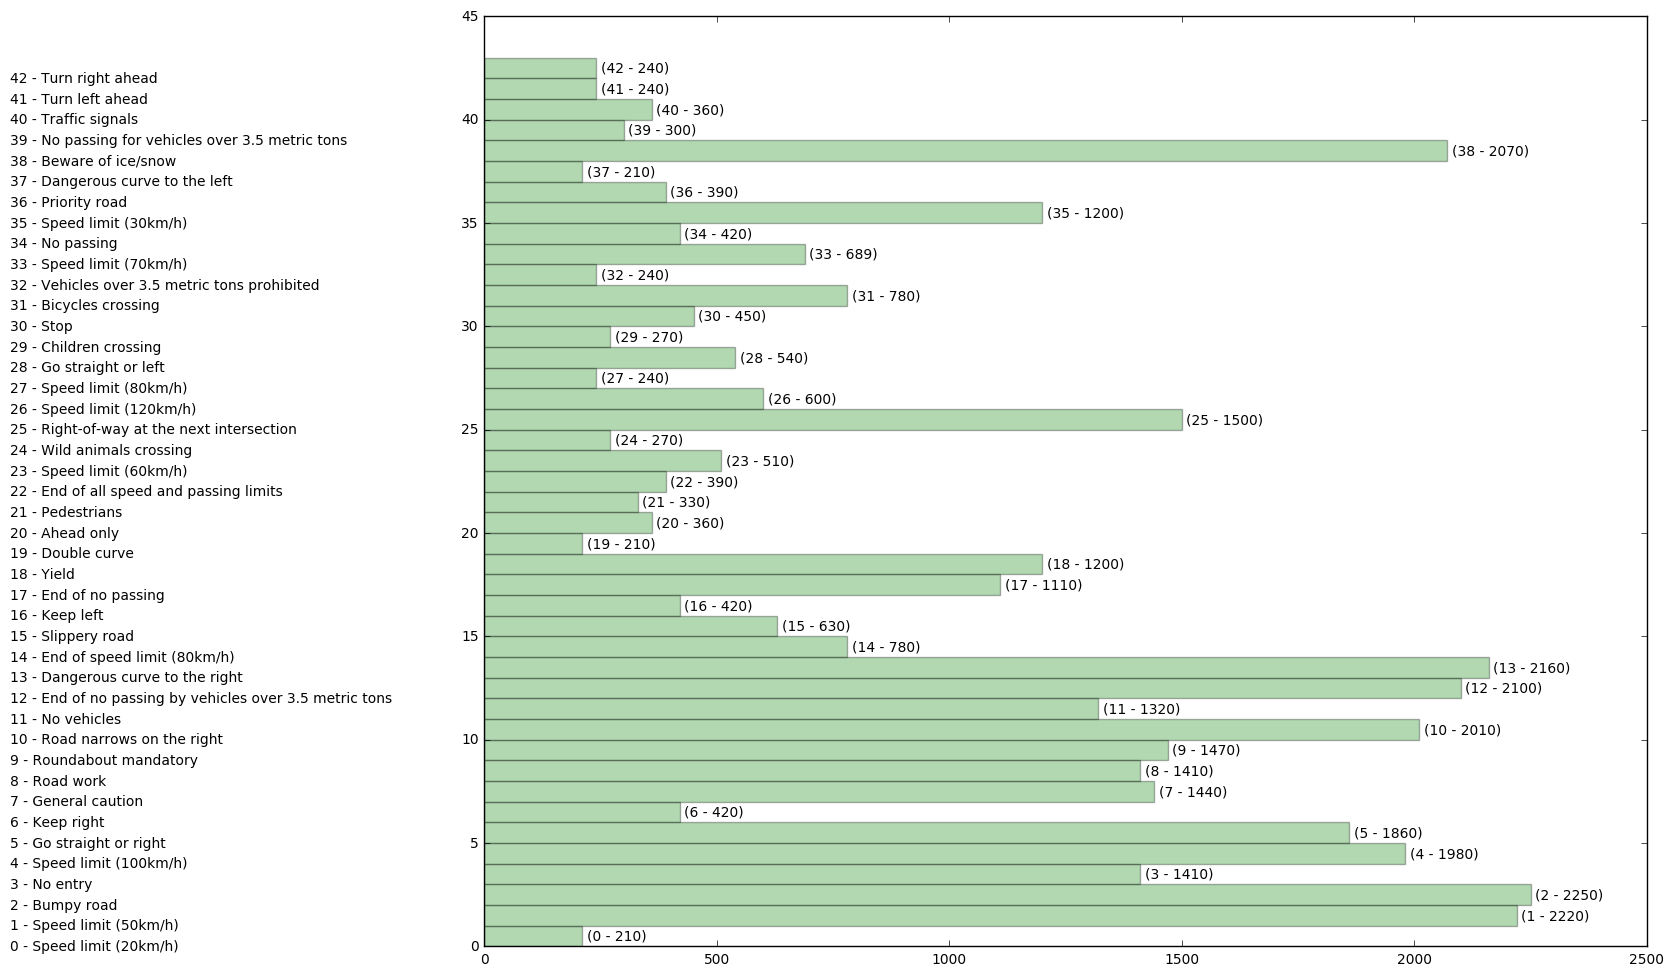

In [14]:
data = group_classes(list(Y))
plot_frequency(list(names.values()), np.array(list(set(Y))), list(data.values()))

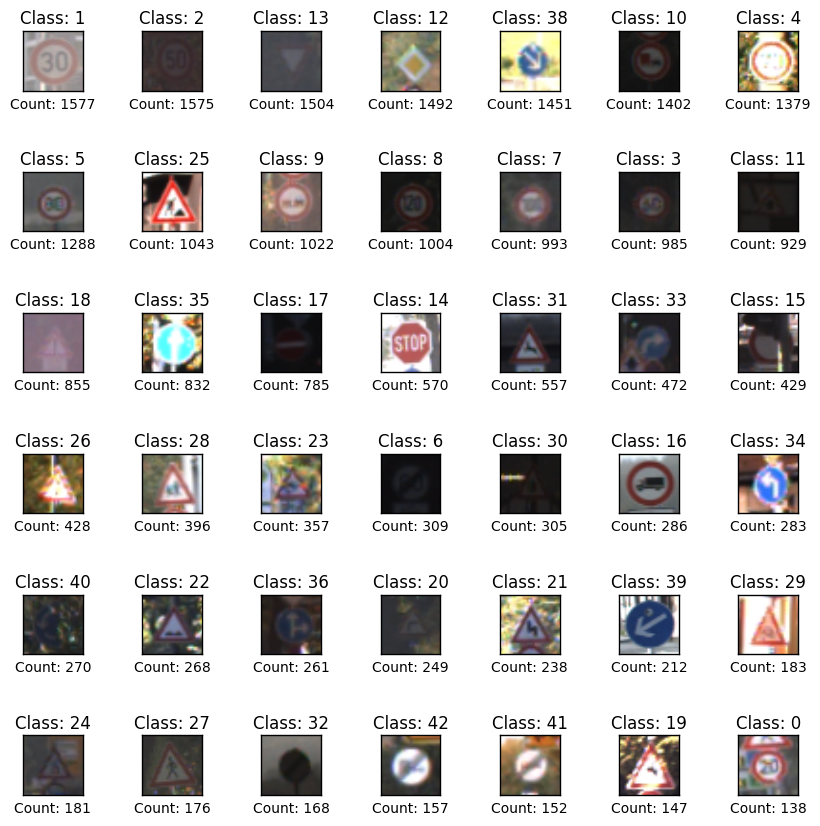

In [15]:
data = group_classes_sorted(sorted(Y_train))
images, labels, counts = get_images_and_counts(X, list(Y), data)
plot_signs(images, labels, counts)

In [16]:
counts = {}

for i in range(len(Y_train)):
    cls = str(Y_train[i])
    if cls not in counts:
        counts[cls] = 1
    else:
        counts[cls] += 1

import operator
sorted_x = sorted(counts.items(), key=operator.itemgetter(1), reverse=True)
for k,v in sorted_x:
    counts[k] = (10000-v)

In [17]:
X_train = list(X_train)

Y_train = list(Y_train)

assert len(X_train) == len(Y_train), 'Unbalanced X, Y lengths'

length = len(X_train)

done = {}

for i in range(len(X_train)):
    cls = str(Y_train[i])
    if cls not in done:
        done[cls] = 0
    if i % 1000 == 0: print("jittering", cls, done[cls])
    for j in range(70):
        if counts[cls] == done[cls]:
            break
        done[cls] = done[cls] + 1 
        img = transform_image(X_train[i], 20, 10, 5)
        X_train.append(img)
        Y_train.append(int(cls))
        
X_train, Y_train = np.array(X_train), np.array(Y_train)

jittering 1 0
jittering 13 3990
jittering 9 4970
jittering 12 8508
jittering 3 9015
jittering 2 8425
jittering 38 8549
jittering 25 8957
jittering 4 8621
jittering 31 9443
jittering 38 8549
jittering 18 9145
jittering 2 8425
jittering 25 8957
jittering 7 9007
jittering 18 9145
jittering 1 8423
jittering 4 8621
jittering 38 8549
jittering 1 8423
jittering 28 9604
jittering 25 8957
jittering 41 8540
jittering 18 9145
jittering 1 8423
jittering 12 8508
jittering 10 8598
jittering 2 8425


In [18]:
counts = {}

for i in range(len(Y_train)):
    cls = str(Y_train[i])
    if cls not in counts:
        counts[cls] = 1
    else:
        counts[cls] += 1

print(counts)

{'0': 9798, '2': 10000, '24': 10000, '21': 10000, '7': 10000, '36': 10000, '38': 10000, '18': 10000, '25': 10000, '11': 10000, '40': 10000, '42': 10000, '15': 10000, '20': 10000, '6': 10000, '23': 10000, '13': 10000, '17': 10000, '35': 10000, '27': 10000, '39': 10000, '3': 10000, '31': 10000, '12': 10000, '8': 10000, '5': 10000, '37': 9798, '14': 10000, '28': 10000, '26': 10000, '29': 10000, '16': 10000, '4': 10000, '9': 10000, '1': 10000, '22': 10000, '41': 10000, '19': 10000, '30': 10000, '10': 10000, '32': 10000, '34': 10000, '33': 10000}


----

## Step 3: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Reference: [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). 

In [19]:
Y_train = dense_to_one_hot(Y_train, num_classes)

Y_val = dense_to_one_hot(Y_val, num_classes)

Y_test =  dense_to_one_hot(y_test, num_classes)

In [20]:
# Image Tensor
images_placeholder = tf.placeholder(tf.float32, shape=[None, 32, 32, 3], name='x')

gray = tf.image.rgb_to_grayscale(images_placeholder, name='gray')

gray /= 255.

# Label Tensor
labels_placeholder = tf.placeholder(tf.float32, shape=(None, 43), name='y')

# dropout Tensor
keep_prob = tf.placeholder(tf.float32, name='drop')

# construct model
logits = inference(gray, keep_prob)

# calculate loss
loss_value = loss(logits, labels_placeholder)

y_pred = tf.nn.softmax(logits)

# training
train_op = training(loss_value, 0.0001)

# accuracy
acc, y_pred_cls = accuracy(logits, labels_placeholder)

saver = tf.train.Saver()

# Merge all the summaries and write them out to /tmp/mnist_logs (by default)
merged = tf.merge_all_summaries()

In [21]:
steps = len(X_train) // BATCH_SIZE
    
train_num_examples = steps * BATCH_SIZE

In [23]:
def evaluate(X_data, y_data):
    Predictions = list()
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    sess = tf.get_default_session()
    acc_steps = len(X_data) // BATCH_SIZE
    for i in range(acc_steps):
        batch_x, batch_y = next_batch(X_data, y_data, BATCH_SIZE)
                   
        summary, loss, accuracy, predictions = sess.run([merged, loss_value, acc, y_pred_cls], feed_dict={
                images_placeholder: batch_x,
                labels_placeholder: batch_y,
                keep_prob: 1.
                })
        Predictions.append(predictions)
        total_accuracy += (accuracy * len(batch_x))
        total_loss += (loss * len(batch_x))
        
    return (summary, total_accuracy / num_examples, total_loss / num_examples, Predictions)

In [26]:
with tf.Session() as sess:
    
    sess.run(tf.initialize_all_variables())
    train_writer = tf.train.SummaryWriter('/Users/rrjing85/AutoDriveCar/Traffic_sign_project/traffic-signs-data/train', sess.graph)
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        for j in range(steps):
            # train for batch_size
            batch_x, batch_y = next_batch(X_train, Y_train, BATCH_SIZE)
            sess.run(train_op, feed_dict={
                images_placeholder: batch_x,
                labels_placeholder: batch_y,
                keep_prob: 0.5})
            
        summary, val_accuracy, val_loss, predictions = evaluate(X_val, Y_val)
        train_writer.add_summary(summary, i)
        print("EPOCH {} ...".format(i+1))
        print("Validation Loss = {:.3f} and Validation Accuracy = {:.3f}".format(val_loss, val_accuracy*100))

    save_path = saver.save(sess, '/Users/rrjing85/AutoDriveCar/Traffic_sign_project/traffic-signs-data/gtsd-final.chkpt')
    print("Model saved in file: %s" % save_path)

Training...

EPOCH 1 ...
Validation Loss = 2.640 and Validation Accuracy = 34.541
EPOCH 2 ...
Validation Loss = 1.319 and Validation Accuracy = 64.660
EPOCH 3 ...
Validation Loss = 0.848 and Validation Accuracy = 76.970
EPOCH 4 ...
Validation Loss = 0.586 and Validation Accuracy = 83.805
EPOCH 5 ...
Validation Loss = 0.418 and Validation Accuracy = 88.897
EPOCH 6 ...
Validation Loss = 0.308 and Validation Accuracy = 91.660
EPOCH 7 ...
Validation Loss = 0.228 and Validation Accuracy = 93.641
EPOCH 8 ...
Validation Loss = 0.177 and Validation Accuracy = 94.967
EPOCH 9 ...
Validation Loss = 0.140 and Validation Accuracy = 96.004
EPOCH 10 ...
Validation Loss = 0.114 and Validation Accuracy = 96.327
EPOCH 11 ...
Validation Loss = 0.095 and Validation Accuracy = 97.016
EPOCH 12 ...
Validation Loss = 0.081 and Validation Accuracy = 97.297


KeyboardInterrupt: 

In [27]:
test_batch_size = 32 

img_shape = (32, 32, 3)

def plot_images(images, cls_true, cls_pred=None):
#     assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(np.argmax(cls_true[i]), np.argmax(cls_pred[i]))

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()


def plot_example_errors(cls_pred, correct, X_data, Y_data):
    
    incorrect = np.array(correct == False)
    print(incorrect)
    images = X_data[incorrect]
    
    cls_pred = cls_pred[incorrect]

    cls_true = Y_data[incorrect]

    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])


def print_test_accuracy(session, predictions, X_data, Y_data):

    num_test = len(predictions)
    _placeholder = tf.placeholder(tf.float32, shape=(None, 43))
    _predictions = tf.placeholder(tf.int64, shape=(num_test,))
    _true = tf.argmax(_placeholder, 1)
    _correct = tf.equal(_true, _predictions)
    cls_true, correct = sess.run([_true, _correct], feed_dict={_placeholder:Y_data, _predictions: predictions})

    correct_sum = correct.sum()

    _acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: ({} / {})"
    print(msg.format(correct_sum, num_test))


    print("Example errors:")
    plot_example_errors(predictions, correct, X_data, Y_data)


In [28]:
with tf.Session() as sess:
    saver.restore(sess, '/Users/rrjing85/AutoDriveCar/Traffic_sign_project/traffic-signs-data/gtsd-final.chkpt')
    print("Model restored.")
    summary, test_accuracy, test_loss, predictions = evaluate(X_test, Y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy*100))
    predictions = np.array([item for sublist in predictions for item in sublist])
    print_test_accuracy(sess, predictions, X_test, np.array(list(Y_test)[:-22]))
    

ValueError: Restore called with invalid save path: '/Users/rrjing85/AutoDriveCar/Traffic_sign_project/traffic-signs-data/gtsd-final.chkpt'. File path is: '/Users/rrjing85/AutoDriveCar/Traffic_sign_project/traffic-signs-data/gtsd-final.chkpt'

### Discussion

1 About how did I preprocessed the data. Why did I choose that technique?_

**Answer:**

For preprocessing I explored several options.  

**1) Using RGB**

Using RGB only yielded a 70% or so validation accuracy

**2) Using YUV**

Many of the images are very dark.  I converted the images to YUV and brightened the Y channel but using this same model I was only able to get 88% validation accuracy

**3) Just Grayscaling**

With the above model and just grayscaling I saw the highest validation accuracy of 93%

All images were of course normalized to reduce computational complexity by dividing each pixel by the value `255`.

---

## Step 4: Test a Model on New Images

Using Google Street Map view of the city of Hamburg, Germany, I was able to screen capture 6 images that match 6 classes from the dataset.
I then cropped the screen shot to only the traffic sign and resized the image to 32X32.
I ran my model aginst these 6 images and where the test data showed ca. 96% accuracy, the model's accuracy on these downloaded images was 100%.

In [18]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import os
from PIL import Image
names = os.listdir('./downloaded-images')
images = [cv2.imread('./downloaded-images/'+img, 1) for img in names]
classes = [int(img.replace('.jpg', '')) for img in names]

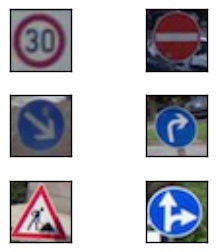

In [19]:
fig, axes = plt.subplots(3, 2, figsize=(3, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, ax in enumerate(axes.flat):
    ax.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB), cmap='binary')
    ax.set_xticks([])
    ax.set_yticks([])

In [20]:
X_downloaded = images
y_downloaded = list()
for _cls in classes:
    y = np.zeros(43, dtype=np.uint8)
    y[_cls] = 1.
    y_downloaded.append(y)

y_downloaded = np.array(y_downloaded)

In [21]:
def evaluate_downloaded(X_data, y_data):
    Predictions = list()
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    sess = tf.get_default_session()

 
    loss, accuracy, predictions = sess.run([loss_value, acc, y_pred_cls], feed_dict={
                images_placeholder: X_data,
                labels_placeholder: y_data,
                keep_prob: 1.
                })

        
    return loss, accuracy, [predictions]



In [22]:

with tf.Session() as sess:
    saver.restore(sess, '/home/ubuntu/gtsd-final.chkpt')
    print("Model restored.")
    test_loss, test_accuracy, predictions = evaluate_downloaded(X_downloaded, y_downloaded)
    print("Test Accuracy = {:.3f}".format(test_accuracy*100))
    predictions = np.array([item for sublist in predictions for item in sublist])


Model restored.
Test Accuracy = 100.000


### Step 5

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 
`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

In [80]:
with tf.Session() as sess:
    saver.restore(sess, '/home/ubuntu/gtsd-final.chkpt')
    print("Model restored.")
    values, indices = sess.run(tf.nn.top_k(y_pred, k=40), feed_dict={images_placeholder: X_test[1000:1005],
                labels_placeholder: Y_test[1000:1005],keep_prob:1.0})
    print(values[0], indices[0])

Model restored.
[  1.00000000e+00   1.62231289e-14   8.79110424e-15   5.81972409e-16
   1.06768635e-16   4.90170588e-17   1.96279355e-17   1.28847866e-18
   8.48072287e-20   1.01836007e-20   1.10995693e-21   1.69406302e-23
   4.66576318e-25   2.37199184e-25   9.05911224e-27   5.12460646e-27
   5.52510060e-29   4.97281130e-29   3.45303832e-29   5.01412513e-30
   2.03209702e-30   1.07836617e-30   4.52639029e-32   3.16475493e-32
   1.31646096e-32   8.08564450e-33   4.89226973e-33   3.31410222e-34
   1.95674265e-35   2.07129177e-37   5.94223360e-38   5.78354048e-38
   2.11439249e-38   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00] [17 14 38  7 40 34 12 10 16 33 42 39  9 37 11  4 30  2  5 23 13 36 25  8  1
 21 41 35 18  6 19 32 20  0  3 15 22 24 26 27]


In [81]:
with tf.Session() as sess:
    saver.restore(sess, '/home/ubuntu/gtsd-final.chkpt')
    print("Model restored.")
    values = sess.run(y_pred, feed_dict={images_placeholder: X_test[1000:1005],
                labels_placeholder: Y_test[1000:1005],keep_prob:1.0})
    print(values[0])

Model restored.
[  0.00000000e+00   1.31646096e-32   4.97281130e-29   0.00000000e+00
   5.12460646e-27   3.45303832e-29   2.07129177e-37   5.81972409e-16
   3.16475493e-32   4.66576318e-25   1.28847866e-18   9.05911224e-27
   1.96279355e-17   2.03209702e-30   1.62231289e-14   0.00000000e+00
   8.48072287e-20   1.00000000e+00   1.95674265e-35   5.94223360e-38
   2.11439249e-38   8.08564450e-33   0.00000000e+00   5.01412513e-30
   0.00000000e+00   4.52639029e-32   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.52510060e-29   0.00000000e+00
   5.78354048e-38   1.01836007e-20   4.90170588e-17   3.31410222e-34
   1.07836617e-30   2.37199184e-25   8.79110424e-15   1.69406302e-23
   1.06768635e-16   4.89226973e-33   1.10995693e-21]


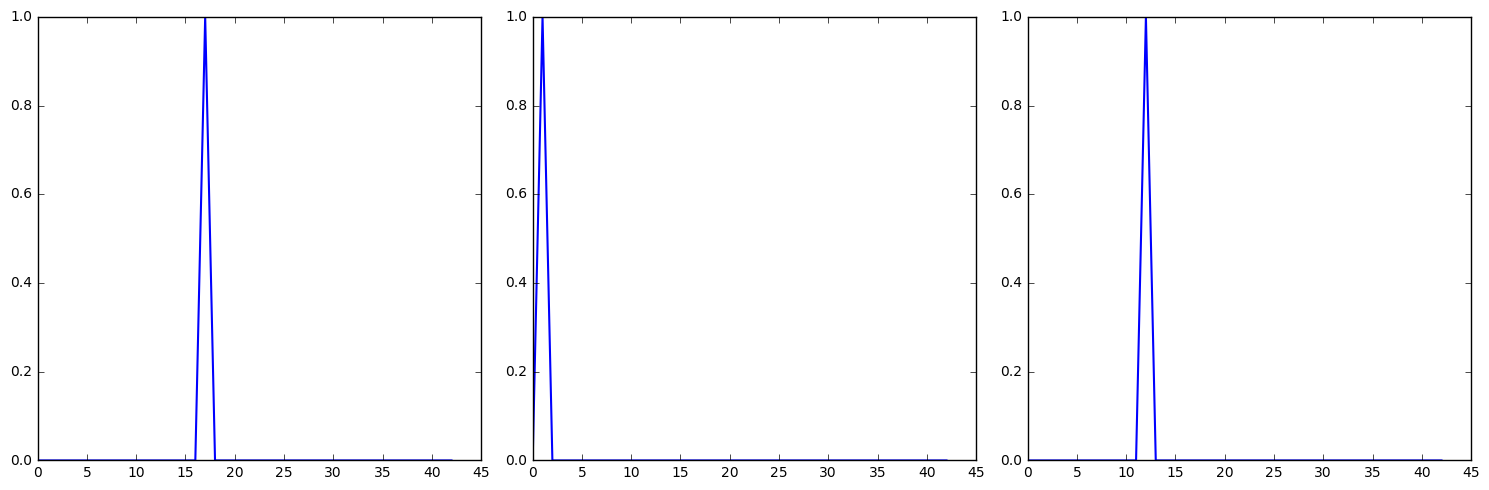

In [82]:
t = np.arange(0, len(values[0]))
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.subplots_adjust(hspace=1, wspace=1)
for i, ax in enumerate(ax.flat):

    ax.plot(t, values[i], linewidth=1.5, color='blue', alpha=1.0, label='name')


# Tweak spacing to prevent clipping of ylabel
plt.tight_layout()